# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
import scipy.signal as signal
import random 
import pywt
from sklearn.cross_decomposition import CCA

# Set Up

In [2]:
# Filtering parameters

low_freq = 5
high_freq = 40
sampling_rate = 250

b, a = signal.butter(4, [low_freq, high_freq], fs=sampling_rate, btype='band')

# We load the additional info with load_ssvep_additional_info and get the indexes and names of all aoccipital electrodes
# We also establish the sampling rate and the number of samples without a stimulus flickering.

sampling_rate = 250
data_frequencies, electrodes_names = utils.load_ssvep_additional_info("Dataset BETA/S1")
occipital_electrodes, occipital_electrodes_indexes, occipital_electrodes_names = utils.select_occipital_electrodes(electrodes_names)

samples_without_stimulus = int(0.5 * sampling_rate)

# Spectrogram

Here we will show part of the process for generating spectrogram plots and selecting the parameters

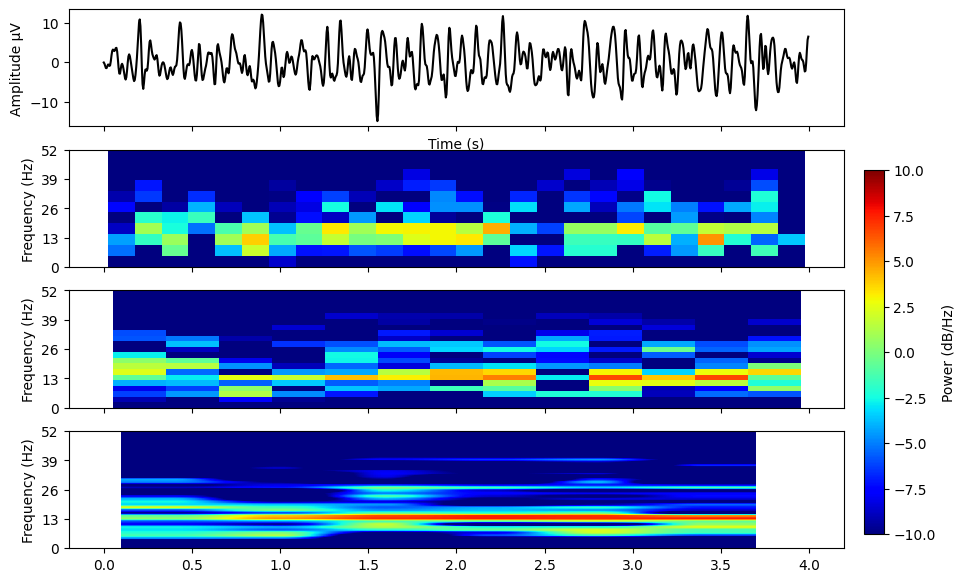

In [13]:
eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",23)
t = np.arange(0, 1000/sampling_rate, 1/sampling_rate)

f_idx = 22
f_value = data_frequencies[f_idx]

# Define the parameters for the spectrogram
fs = sampling_rate  # Sampling frequency
data = eeg_data[61, :, 0, f_idx]
filtered_data = signal.lfilter(b, a, data)

# Compute and plot the spectrogram
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 7), sharex=True)

# Plot the first plot (ax1) with the same time range as the spectrograms
ax1.plot(t, filtered_data, 'k') 
ax1.set_ylabel("Amplitude " + '\u03BC' + "V")
ax1.set_xlabel("Time (s)")
ax1.set_xlim(0, 4) 

frequency_range = (0, 50)

# Set vmin and vmax for the spectrograms to cover the entire range of the data
vmin = -10
vmax = 10

window_lengths = [50, 100, 200]  # Length of the window for computing the spectrogram
overlap = [int(x / 4) for x in window_lengths]  # Overlap between consecutive windows

# Plot spectrograms with limited frequency range
Pxx, freqs, bins, im = ax2.specgram(filtered_data, NFFT=window_lengths[0], Fs=fs, noverlap=overlap[0], cmap='jet', vmin=vmin, vmax=vmax)
#ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_ylim(frequency_range)
ax2.set_yticks([0, f_value, f_value * 2, f_value * 3, f_value * 4])
ax2.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
ax2.set_xlim(0, 4) 

Pxx, freqs, bins, im = ax3.specgram(filtered_data, NFFT=window_lengths[1], Fs=fs, noverlap=overlap[1], cmap='jet', vmin=vmin, vmax=vmax)
#ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_ylim(frequency_range)
ax3.set_yticks([0, f_value, f_value * 2, f_value * 3, f_value * 4])

Pxx, freqs, bins, im = ax4.specgram(filtered_data, NFFT=window_lengths[2], Fs=fs, noverlap=overlap[2], cmap='jet', vmin=vmin, vmax=vmax)
#ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_ylim(frequency_range)
ax4.set_yticks([0, f_value, f_value * 2, f_value * 3, f_value * 4])
#ax4.axhline(13, color="black", linewidth=2)

# Create colorbars next to the first plot
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.52])
cbar = plt.colorbar(im, cax=cbar_ax, label='Power (dB/Hz)')

plt.show()

# Wavelet Transform

Here we will show part of the process for generating wavelet transform plots and selecting the parameters

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_28935/272054720.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


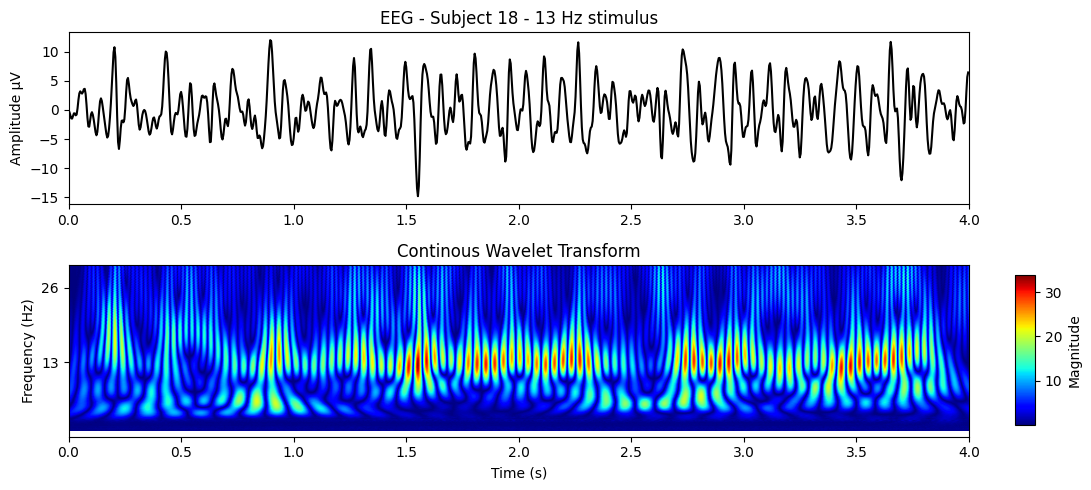

In [19]:
eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",23)
t = np.arange(0, 1000/sampling_rate, 1/sampling_rate)

sampling_rate = 250

filtered_data = signal.lfilter(b, a, eeg_data[61, :, 0, 22])

frequencies = np.arange(1, 40, 0.01) /sampling_rate 
wavelet_name = "morl"
# Pasamos de frecuencias a escalas para utilizarlas en la transformada
scales = pywt.frequency2scale(wavelet_name, frequencies) 
# Transformada Wavelet
cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name) 
# Multiplicamos por samping_rate para recuperar las frecuencias en Hz
frequencies = frequencies*sampling_rate 

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 5))

ax1.plot(t,filtered_data, 'k')
ax1.set_xlim(0, 4)
ax1.set_ylabel("Amplitude " + '\u03BC' + "V")
ax1.set_title("EEG - Subject 18 - 13 Hz stimulus")

ax2.imshow(np.abs(cwtmatr), aspect='auto', cmap='jet', extent=[0, len(t) / sampling_rate, frequencies[-1], frequencies[0]], origin='upper')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title("Continous Wavelet Transform")
ax2.set_ylim(0, 30)
ax2.set_yticks([13, 26])
cbar_ax2 = fig.add_axes([1.02, 0.14 , 0.02, 0.3])
plt.colorbar(ax2.images[0], cax=cbar_ax2, label="Magnitude")


plt.tight_layout()

# Specific times

We will load the sliding windows data to get the areas we need to shade in our images

In [6]:
#Load data
sliding_detections_m_psda = utils.load_data("Saved data/sliding_m_psda.h5")
sliding_detections_cca = utils.load_data("Saved data/sliding_cca.h5")

Data loaded successfully from Saved data/sliding_m_psda.h5
Data loaded successfully from Saved data/sliding_cca.h5


In [7]:
def print_trial_time(subject, freq_idx):
    for i in range(4):
        if (sliding_detections_cca[subject-1, i, freq_idx] != -1):
            print("Subject ", subject, "sample for frequency ", data_frequencies[freq_idx], "Hz is ", sliding_detections_cca[subject-1, i, freq_idx])
        else:
            print("Failed to detect the frequency ", data_frequencies[freq_idx], "Hz with CCA for subject ", subject) 

def detected_sample(subject, freq_idx, trial, data):   
    return data[subject-1, trial, freq_idx]    

## m_PSDA

In [8]:
samples = []

subjects = [18, 64, 11, 67]
freq_indexes = [12, 22, 0, 35]

for subject in subjects:
    for freq_idx in freq_indexes:
        for tr in range(4):
            samples.append(detected_sample(subject, freq_idx, tr, sliding_detections_m_psda))

print(samples)

[125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, -1.0, -1.0, 125.0, -1.0, -1.0, -1.0, -1.0, -1.0, 215.0, 125.0, 125.0, 205.0, 605.0, 555.0, 415.0, 165.0, -1.0, 135.0, -1.0, 395.0, -1.0, -1.0, -1.0, -1.0, 195.0, 135.0, 355.0, 355.0, 125.0, 345.0, 235.0, 355.0, 125.0, 125.0, 255.0, 185.0, -1.0, -1.0, -1.0, -1.0, 125.0, 235.0, 325.0, 125.0, 135.0, 125.0, 285.0, 225.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


In [9]:
m_psda_samples = samples

## CCA

In [10]:
samples = []

subjects = [18, 64, 11, 67]
freq_indexes = [12, 22, 0, 35]

for subject in subjects:
    for freq_idx in freq_indexes:
        for tr in range(4):
            samples.append(detected_sample(subject, freq_idx, tr, sliding_detections_cca))

print(samples)

[185.0, 165.0, 125.0, 185.0, 125.0, 145.0, 155.0, 155.0, 255.0, 155.0, 135.0, 145.0, 145.0, 125.0, 125.0, 205.0, 215.0, 125.0, 135.0, 215.0, 605.0, 585.0, 445.0, 275.0, -1.0, -1.0, 685.0, -1.0, 525.0, -1.0, -1.0, -1.0, 185.0, -1.0, -1.0, -1.0, 465.0, -1.0, -1.0, 395.0, 415.0, 495.0, 235.0, 175.0, 405.0, -1.0, -1.0, 325.0, 125.0, 205.0, 325.0, 125.0, 395.0, 185.0, 565.0, 405.0, 125.0, 125.0, 145.0, 125.0, 485.0, 545.0, 645.0, 625.0]


In [11]:
cca_samples = samples

# Final Image generation

In [27]:
# Windows parameters
window_length = int(750/3) #We chose 750 because it is the shortest trial duration
window_step = 10 #int(750/24)

print("Window length = ",window_length)
print("Window step = ", window_step)
print("Number of steps = ", len(np.arange(0, 750, step=window_step)), " and ", len(np.arange(0, 1000, step=window_step)))

Window length =  250
Window step =  10
Number of steps =  75  and  100


In [23]:
# Formatting the shading samples

samples = np.zeros((64, 2))
print(samples.shape)

for i in range(samples.shape[0]):
    #samples[i, 0] = psda_samples[i]
    samples[i, 0] = m_psda_samples[i]
    samples[i, 1] = cca_samples[i]

(64, 2)


## Spectrogram, Wavelet and FFT

In [28]:
samples_index = 0

sampling_rate = 250
subject = 41
path = "Dataset BETA/S" + str(subject) +".mat"
data_frequencies, electrodes_names = utils.load_ssvep_additional_info(path)
occipital_electrodes, occipital_electrodes_indexes, occipital_electrodes_names = utils.select_occipital_electrodes(electrodes_names)

samples_without_stimulus = int(0.5 * sampling_rate)

eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",18)

frequencies = [[11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6]]


subjects = [18, 18, 64, 64, 11, 11, 67, 67]
cases = ["best", "worst", "best", "worst", "paper_worst_best", "paper_worst_worst", "paper_best_best", "paper_best_worst"]

data_frequencies[-5] = 15.6

electrode_idx = 61
electrode_name = "OZ"

for i in range(len(subjects)):
    subject = subjects[i]
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",subject)
    case = cases[i]
    for j in range(2):
        index = j+1
        fr_idx = 0
        freq = frequencies[i][j]
        for x in range(40):
            if data_frequencies[x] == freq:
                fr_idx = x
                break
                    
        for tr_idx in range(4):
            path = "../Imágenes/Results/"
            path += "S"+str(subject)+"_"+electrode_name+"_"+case+"_"+str(index)+"_T"+str(tr_idx)+".png"
            #utils.plot_generation_three(eeg_data[electrode_idx, :, tr_idx, fr_idx], sampling_rate, fr_idx, data_frequencies, False, True, path, shading_sample = detected_sample(subject, fr_idx, tr_idx), shading_size = window_length)
            utils.plot_generation_spectrogram_wavelet(eeg_data[electrode_idx, :, tr_idx, fr_idx], sampling_rate, fr_idx, data_frequencies, False, True, path, shading_samples = samples[samples_index], shading_size = window_length)

            path = "../Imágenes/Results/"
            path += "S"+str(subject)+"_"+electrode_name+"_"+case+"_"+str(index)+"_T"+str(tr_idx)+"_FFT.png"
            utils.plot_generation_fft(eeg_data[electrode_idx, :, tr_idx, fr_idx], sampling_rate=sampling_rate, frequency=data_frequencies[fr_idx], show_plot=False, save_plot=True, path=path)

            samples_index += 1

print("DONE!")

/Users/tania/Desktop/Tania/Universidad/TFM/Sequential-Characterization-of-SSVEP-EEG-signals/utils.py:338: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


DONE!


## Highest magnitudes over time + average difference in Hz

Here we have the image generation for the subjects under study.

In [4]:
samples_index = 0

sampling_rate = 250
subject = 41
path = "Dataset BETA/S" + str(subject) +".mat"
data_frequencies, electrodes_names = utils.load_ssvep_additional_info(path)
occipital_electrodes, occipital_electrodes_indexes, occipital_electrodes_names = utils.select_occipital_electrodes(electrodes_names)

samples_without_stimulus = int(0.5 * sampling_rate)

eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",18)

frequencies = [[11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6]]


subjects = [18, 18, 64, 64, 11, 11, 67, 67]
cases = ["best", "worst", "best", "worst", "paper_worst_best", "paper_worst_worst", "paper_best_best", "paper_best_worst"]

data_frequencies[-5] = 15.6

electrode_idx = 61
electrode_name = "OZ"

for i in range(len(subjects)):
    subject = subjects[i]
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",subject)
    case = cases[i]
    for j in range(2):
        index = j+1
        fr_idx = 0
        freq = frequencies[i][j]
        for x in range(40):
            if data_frequencies[x] == freq:
                fr_idx = x
                break
        for tr_idx in range(4):
            path = "../Imágenes/Results/Highest_magnitudes/S" + str(subject) + "_F" + str(freq) + "_T" + str(tr_idx) +"_Highest_magnitudes.png"
            utils.highest_magntiudes(eeg_data[electrode_idx, :, tr_idx, fr_idx], freq, sampling_rate, path)
            
print("DONE!")

This is the individual results for a subject. We can obtain the average difference in Hz filtering and not filtering difference above 5 Hz. we can change the subject and stimulus frequency as needed.

In [ ]:
subject = 18
frequency = 11

data_frequencies[35] = 15.6

fr_idx = 0
freq = frequency
for x in range(40):
    if data_frequencies[x] == freq:
        fr_idx = x
        break  



eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",subject)

for tr_index in range(0, 4):

    filtered_data = signal.lfilter(b, a, eeg_data[61, :, tr_index, fr_idx])

    freqs = np.arange(1, 40, 0.01) /sampling_rate 
    wavelet_name = "morl"
    # Pasamos de frecuencias a escalas para utilizarlas en la transformada
    scales = pywt.frequency2scale(wavelet_name, freqs) 
    # Transformada Wavelet
    cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name)

    # Filter out magnitudes below 20
    cwtmatr_filtered = np.where(cwtmatr < 25, 0, cwtmatr)
    # Find the index of the maximum magnitude along the frequency axis for each time step
    max_freq_indices = np.argmax(cwtmatr_filtered, axis=0)
    # Extract the corresponding frequencies for each time step
    frequencies = np.arange(1, 40, step=0.01)
    max_freq_values = frequencies[max_freq_indices]

    result = 0
    total = 0

    result_2 = 0
    total_2 = 0

    for i in range(int(1*250), int(len(max_freq_values) - (0.5*250))):
        if max_freq_values[i] != 1:
            if np.abs(frequency - max_freq_values[i]) < 5 :
                result += np.abs(frequency - max_freq_values[i])
                total += 1
            total_2 += 1
            result_2 +=  np.abs(frequency - max_freq_values[i])
        

    print("Trial ", tr_index + 1, " average thickness = ", result_2/total_2, "  filtered = ", result/total)


Trial  1  average thickness =  1.3848412698412682   filtered =  0.5487499999999987
Trial  2  average thickness =  0.59020408163265   filtered =  0.59020408163265
Trial  3  average thickness =  0.7833766233766247   filtered =  0.4249315068493159
Trial  4  average thickness =  0.6006557377049161   filtered =  0.6006557377049161
